In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
# import warnings
# warnings.filterwarnings("ignore")

import jax
from jax import lax, jit, vmap, value_and_grad
import jax.random as jr
import jax.numpy as jnp
import jax.scipy.stats as jstats
import pandas as pd
import numpy as np
from tinygp import GaussianProcess, kernels, transforms
import optax
import equinox as eqx
import numpy as np
from functools import partial
from typing import NamedTuple, Callable, Optional
from jaxtyping import Float, Array

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0);

# Example of Gaussian Process Surrogate

## Model for subcutaneous autoinjectors

In this notebook, we'll repeat the neural network surrogate hands-on activity, but this time we'll use a gaussian process (GP) as the surrogate. 
Recall that our goal is to replicate [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695), i.e., create a surrogate of an expensive biomechanical model.

Just to recap: We have a high-fidelity, finite-element-based model $f$ of drug autoinjections. 
The model takes inputs $x$ like drug viscosity, tissue biomechanical properties, etc. and calculates various outputs $y=f(x)$. 
To train a surrogate $\hat{f}$ of this model, we have a dataset  containing thousands of evaluations of $f$. 
For further details about the model or dataset, see the neural network surrogate hands-on activity. 

Let's get the data imported. (We'll follow the same preprocessing steps as the neural network surrogate hands-on activity, except we won't re-explain the steps here&mdash;we'll just do them.)

In [2]:
# Define new names for each input/output variable
old_input_names = ['mu', 'fill_volume', 'hGap0', 'lNeedle', 'dNeedle', 'FSpring0', 'kSpring', 'kappa5', 'kappa6', 'kappa7']
INPUT_NAMES = ['viscosity_cP', 'fill_volume_mL', 'air_gap_height_mm', 'needle_length_mm', 'needle_diameter_mm', 'spring_force_N', 'spring_constant_N_per_mm', 'kappa5', 'kappa6', 'kappa7']
old_output_names = ['Needle displacement (m)', 'Injection time (s)', 'max. acceleration (m/s^2)', 'max. deceleration (m/s^2)']
OUTPUT_NAMES = ['needle_displacement_m', 'injection_time_s', 'max_acceleration_m_per_s2', 'max_deceleration_m_per_s2']
column_name_mapper = dict(zip(old_input_names + old_output_names, INPUT_NAMES + OUTPUT_NAMES))

# Load the data
train_data = pd.read_excel("https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/autoinjector_surrogate/training_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)
test_data = pd.read_excel("https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/autoinjector_surrogate/test_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)

# Split data. Pass in column names to ensure correct order.
X_train = pd.DataFrame(train_data[INPUT_NAMES], columns=INPUT_NAMES)  
y_train = pd.DataFrame(train_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)
X_test = pd.DataFrame(test_data[INPUT_NAMES], columns=INPUT_NAMES)
y_test = pd.DataFrame(test_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)

# Set up scalers
X_train_mean = np.mean(X_train.values, axis=0)
X_train_std = np.std(X_train.values, axis=0)
y_train_mean = np.mean(y_train.values, axis=0)
y_train_std = np.std(y_train.values, axis=0)

def build_standard_scaler(data: Float[Array, "N d"]) -> tuple[Callable[[Array], Array], Callable[[Array], Array]]:
    """Factory function to build a standard scaler for the given data."""
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scale = lambda x: (x - mean) / std
    unscale = lambda x: x * std + mean
    return scale, unscale

def build_log_scaler(data: Float[Array, "N d"]) -> tuple[Callable[[Array], Array], Callable[[Array], Array]]:
    """Factory function to build a log scaler for the given data."""
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scale = lambda x: (jnp.log(x) - mean) / std
    unscale = lambda x: jnp.exp(x * std + mean)
    return scale, unscale

# Input scaler
scale_x, unscale_x = build_standard_scaler(X_train.values)

# Separate scalers for each output
scale_y0, unscale_y0 = build_standard_scaler(y_train.values[:, 0].reshape(-1, 1))
scale_y1, unscale_y1 = build_standard_scaler(y_train.values[:, 1].reshape(-1, 1))
scale_y2, unscale_y2 = build_standard_scaler(y_train.values[:, 2].reshape(-1, 1))
scale_y3, unscale_y3 = build_standard_scaler(y_train.values[:, 3].reshape(-1, 1))

# Combine scalers for all outputs (for convenience)
scale_y = lambda y: jnp.column_stack([scale_y0(y[..., 0]), scale_y1(y[..., 1]), scale_y2(y[..., 2]), scale_y3(y[..., 3])])
unscale_y = lambda y: jnp.column_stack([unscale_y0(y[..., 0]), unscale_y1(y[..., 1]), unscale_y2(y[..., 2]), unscale_y3(y[..., 3])])

In [3]:
X_train_scaled = scale_x(X_train.values)
y_train_scaled = scale_y(y_train.values)
X_test_scaled = scale_x(X_test.values)
y_test_scaled = scale_y(y_test.values)

The data are now imported and standardized. Let's visualize to make sure things look good:

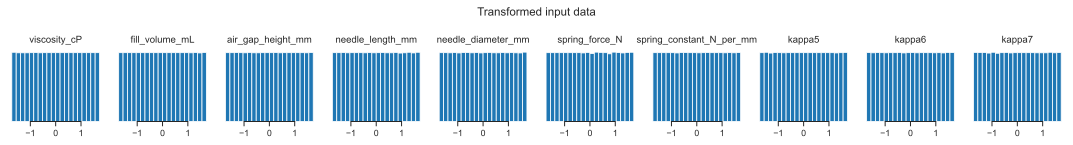

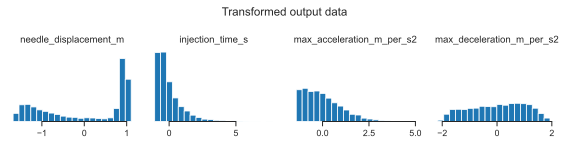

In [4]:
fig, ax = plt.subplots(1, X_train_scaled.shape[1], figsize=(15, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed input data")
for i, i_name in enumerate(INPUT_NAMES):
    ax[i].hist(X_train_scaled[:, i], bins=20)
    ax[i].set_title(i_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

fig, ax = plt.subplots(1, y_train_scaled.shape[1], figsize=(8, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed output data")
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_train_scaled[:, i], bins=20)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

Nice! The input/output data are all more-or-less evenly distributed and standarized. Now on to building the Gaussian process surrogate.

## Gaussian process regression

To demonstrate, we will use `tinygp` to build a GP surrogate for one of the outputs.
Let's pick injection time as the output to model.
Our surrogate will be a GP with a zero-mean function with a radial basis function (RBF) kernel.

$$
f \sim \operatorname{GP}(m, k).
$$

$$
k(x, x') = \sigma^2 \exp\left(-\frac{1}{2} \sum_{i=1}^d \left(\frac{x_i - x'_i}{\ell_i}\right)^2\right)
$$

where $\sigma^2$ is the variance and $\ell_i$ is the length scale for input dimension $i$.

Here is how to implement this in `tinygp`. 
First, we'll create a function that generates a `tinygp.GaussianProcess` object. 

In [5]:
def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.
    
    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data input locations.
    
    Returns
    -------
    GaussianProcess
        The GP.
    """
    amplitude = jnp.exp(params['log_amplitude'])
    lengthscale = jnp.exp(params['log_lengthscale'])
    noise_variance = jnp.exp(params['log_noise_variance'])
    k = amplitude*transforms.Linear(1/lengthscale, kernels.ExpSquared())
    return GaussianProcess(kernel=k, X=X, diag=noise_variance)

### Optimizing hyperparameters

The hyperparameters are the (logs of) the kernel amplitude $\sigma$, length scales $\ell = (\ell_1, \dots, \ell_d)$, and the measurement noise level $\sigma_n$. 
Let's set these hyperparameters to some arbitrary values for now. (They will be optimized later.)

In [6]:
init_params = {
    'log_amplitude': 1.0, 
    'log_lengthscale': -jnp.ones(10),  # Different lengthscale for each input dimension
    'log_noise_variance': -4.0
}

Now we will optimize the hyperparameters by maximizing the marginal log-likelihood.
Here are the loss and train functions:

In [7]:
def loss(params, X, y):
    """Negative marginal log likelihood of the GP."""
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@eqx.filter_jit
def train_step_adam(carry, _, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(loss)(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(init_params, X, y, num_iters, learning_rate, batch_size, key):
    """Optimize the hyperparameters (xi) of a GP using the Adam optimizer.
    
    Parameters
    ----------
    init_params : dict
        Initial values of the hyperparameters.
    X, y: ndarray
        Training data.
    num_iters : int
        Number of optimization steps.
    learning_rate : float
        Learning rate for the optimizer.
    
    Returns
    -------
    dict
        The optimized hyperparameters.
    ndarray
        The loss values at each iteration.
    """
    
    # Initialize the optimizer
    optim = optax.adam(learning_rate)

    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)

    # Do optimization
    train_step = partial(train_step_adam, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)

    return carry[0], losses  # (optimized params, loss values)

We'll only use 200 data points. (Standard GPs are slow with large datasets, so we'll use a subset of the data for demonstration purposes.) Here we go:

In [8]:
# Grab a subset of the training data
idx_output = 1  # Corresponds to injection time
idx_subsample = np.random.choice(X_train_scaled.shape[0], size=200)
X_train_scaled_sub = X_train_scaled[idx_subsample]
y_train_scaled_injection_time = y_train_scaled[idx_subsample, idx_output]

# Optimize the hyperparameters of the GP
key, subkey = jr.split(key)
trained_params, losses = train_gp(init_params, X_train_scaled_sub, y_train_scaled_injection_time, num_iters=1000, learning_rate=1e-2, batch_size=100, key=subkey)

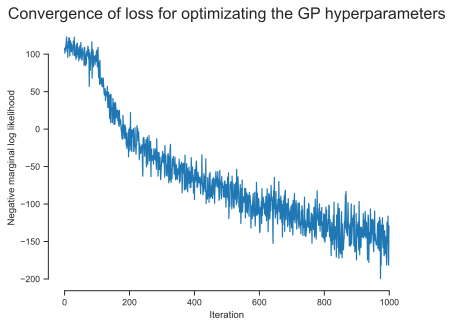

In [9]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative marginal log likelihood")
ax.set_title("Convergence of loss for optimizating the GP hyperparameters", fontsize=16)
sns.despine(trim=True);

Great! We now have a set of optimized hyperparameters.

### Conditioning the GP
Let's condition the GP on the training data and compute it's mean at some arbitrary point. Here is how to do it with `tinygp`:

In [10]:
# First, build the GP with the trained hyperparameters
gp = build_gp(trained_params, X_train_scaled_sub)

# Next, pick a point at which to evaluate the GP
X_eval = jnp.zeros((1, 10))  # Must be shape (n_pts, n_dim)

# Finally, condition the GP on the training data
_, cond_gp = gp.condition(y_train_scaled_injection_time, X_eval)  # Returns (log marginal probability, conditioned GP)

# The surrogate model is the mean of the conditioned GP
mean = cond_gp.mean

# We can also draw samples of the GP at this point (which will just be samples from a univariate Gaussian)
key, subkey = jr.split(key)
samples = cond_gp.sample(subkey, shape=(5000,))

Note that `cond_gp` is just another `tinygp.GaussianProcess` object. 
Let's plot the samples we've just collected in a histogram:

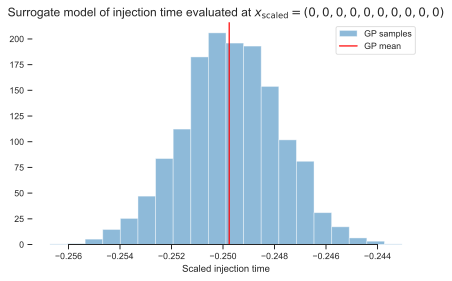

In [11]:
def samples_hist_plot(samples, mean, xlabel):
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    ax.hist(samples, bins=20, density=True, alpha=0.5, label="GP samples")
    ax.axvline(mean, color='red', label="GP mean")
    ax.set_title(r"Surrogate model of injection time evaluated at $x_\text{scaled}=(0,0,0,0,0,0,0,0,0,0)$", fontsize=12)
    ax.set_xlabel(xlabel)
    # ax.set_ylabel("Density")
    ax.legend()
    sns.despine(trim=True, ax=ax, left=True);

samples_hist_plot(samples, mean, "Scaled injection time")
# samples_hist_plot(unscale_y1(samples), np.mean(unscale_y1(samples)), "Injection time (s)")

## Diagnostics: How good is the surrogate?

The next question is: **How accurate is our surrogate?** We will use our test dataset to find out.

### Parity plot

Let's plot the predicted output against the true output (for the test dataset):

In [12]:
_, cond_gp = gp.condition(y_train_scaled_injection_time, X_train_scaled_sub)
means_train = cond_gp.mean
stdevs_train = jnp.sqrt(cond_gp.variance)

_, cond_gp = gp.condition(y_train_scaled_injection_time, X_test_scaled)
means_test = cond_gp.mean
stdevs_test = jnp.sqrt(cond_gp.variance)

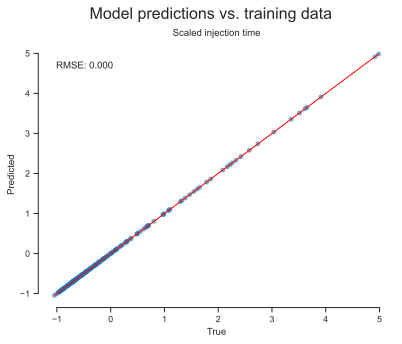

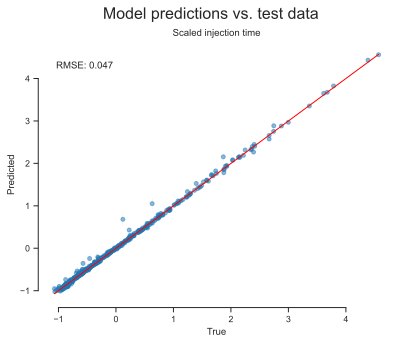

In [13]:
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. training data', fontsize=16)
ax.errorbar(y_train_scaled_injection_time, means_train, yerr=2 * stdevs_train, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_train_scaled_injection_time.min(), y_train_scaled_injection_time.max()], [y_train_scaled_injection_time.min(), y_train_scaled_injection_time.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_train_scaled_injection_time, means_train):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
ax.set_title('Scaled injection time')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

y_test_scaled_injection_time = y_test_scaled[:, 1]

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. test data', fontsize=16)
ax.errorbar(y_test_scaled_injection_time, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled_injection_time.min(), y_test_scaled_injection_time.max()], [y_test_scaled_injection_time.min(), y_test_scaled_injection_time.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_test_scaled_injection_time, means_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
ax.set_title('Scaled injection time')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted');

As expected, we've fit the training data perfectly (all points lie on the red line). However, we mostly care about how well we predict unseen (test) data. The fit looks decent.

For GPs, parity plots and RSME values are good for checking if our predictive *mean* function is correct. However, they do not say anything about whether our *uncertainty* estimates are correct. For that, we must look at the standardized errors.

### Standardized errors

For the $i^\text{th}$ test data point, the *standardized error* $e_i$ is

$$
e_i = \frac{y_i - m(x_i)}{\sigma(x_i)}
$$

where $y_i$ is the true output, and $m(x_i)$ and $\sigma(x_i)$ are the mean and standard deviation of the prediction, respectively.

In [14]:
standardized_errors = (y_test_scaled_injection_time - means_test) / stdevs_test

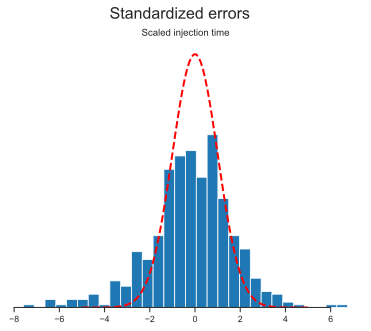

In [15]:
fig, ax = plt.subplots()
fig.suptitle('Standardized errors', fontsize=16)
ax.hist(standardized_errors, bins=30, density=True)
x = jnp.linspace(-5, 5, 100)
y = jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * jnp.pi)
ax.plot(x, y, 'r--', lw=2)
ax.set_title('Scaled injection time')
ax.set_yticks([])
sns.despine(trim=True, ax=ax, left=True);

#### QQ plot

The histogram above looks kind of like a normal distributions, but it's sometimes hard to tell.
A quantile-quantile (QQ) plot is another way to check normality:

In [16]:
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

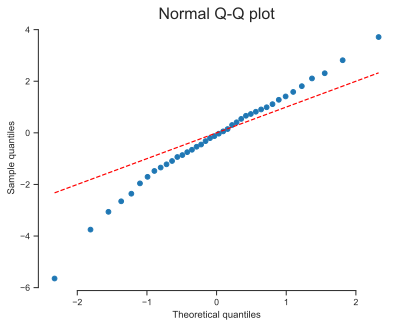

In [17]:
fig, ax = plt.subplots()
ax.plot(normal_quantiles, error_quantiles, 'o')
ax.plot(normal_quantiles, normal_quantiles, 'r--')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.set_title('Normal Q-Q plot', fontsize=16)
sns.despine(trim=True, ax=ax);

The straighter the line, the more "normal" the errors are. They look decent.

#### Residuals plot

Another assumption in our GP model is that the noise is *homoscedastic*&mdash;i.e., the same across all input/output values. We can check this assumption by plotting the error against the model prediction. This is called a *residual plot*. (Note that *residuals* is just another name for the errors.)

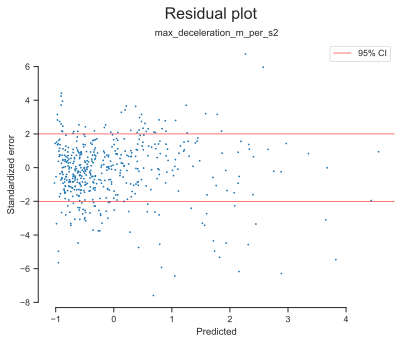

In [18]:
fig, ax = plt.subplots()
fig.suptitle('Residual plot', fontsize=16)
ax.scatter(means_test, standardized_errors, 1)
ax.set_title(o_name)
ax.axhline(-2, color='r', lw=0.5, label=r'95% CI')
ax.axhline(2, color='r', lw=0.5)
sns.despine(trim=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Standardized error')
ax.legend();

Not too bad.

## Multiple outputs

Let's now build a surrogate for all four outputs. 
We will do this by building a GP for each output independently.
This is implemented below:

In [19]:
def create_dataset(size=None, X=X_train_scaled, y=y_train_scaled):
    idx = np.random.choice(X.shape[0], size=size)
    return X[idx], y[idx]

def train_gps(init_params, X, Y, num_iters, learning_rate, batch_size, key):
    """Optimize a different set of GP hyperparameters for each output variable."""
    keys = jr.split(key, len(OUTPUT_NAMES))
    trained_params = {}
    loss_histories = {}
    for i, o_name in enumerate(OUTPUT_NAMES):
        print(f"Training GP for {o_name}")
        y = Y[:, i]
        trained_params_i, losses_i = train_gp(init_params, X, y, num_iters, learning_rate, batch_size, keys[i])
        trained_params[o_name] = trained_params_i
        loss_histories[o_name] = losses_i
    return trained_params, loss_histories

class Surrogate(eqx.Module):
    """A Gaussian process surrogate with multiple inputs and outputs.
    
    Parameters
    ----------
    gps : list[dict]
        A list of dictionaries, each containing the hyperparameters of a GP for a different output variable.
    y_obs : Float[Array, "n_data n_outputs"]
        The observed output data.
    """
    gps: list[dict]
    y_obs: Float[Array, "n_data n_outputs"]
    
    @eqx.filter_jit
    def mean(self, X):
        """Evaluate the unscaled model."""
        y = []
        for i in range(self.num_outputs):
            _, cond_gp = self.gps[i].condition(self.y_obs[:, i], X)
            y.append( cond_gp.mean )
        return jnp.stack(y, axis=-1)
    
    @eqx.filter_jit
    def sample(self, X, num_samples, *, key):
        """Sample the output."""
        samples = []
        for i in range(self.num_outputs):
            key, subkey = jr.split(key)
            _, cond_gp = self.gps[i].condition(self.y_obs[:, i], X)
            samples.append( cond_gp.sample(subkey, shape=(num_samples,)) )
        return jnp.stack(samples, axis=-1)
    
    @property
    def num_outputs(self):
        return len(self.gps)

In [20]:
X_train_scaled_sub, y_train_scaled_sub = create_dataset(size=200)
key, subkey = jr.split(key)
trained_params, _ = train_gps(init_params, X_train_scaled_sub, y_train_scaled_sub, num_iters=1000, learning_rate=1e-2, batch_size=100, key=subkey)

# Create a GP for each output variable
gps = [build_gp(trained_params[o_name], X_train_scaled_sub) for o_name in OUTPUT_NAMES]

surrogate = Surrogate(gps=gps, y_obs=y_train_scaled_sub)

Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP for max_deceleration_m_per_s2


Though not necessary, we have packaged the surrogate into an equinox model `Surrogate` for convenience. Here is how we can evaluate the surrogate at some $X$:

In [21]:
# Pick an input point
X = jnp.array([
    10.0,  # viscosity_cP
    1.02,  # fill_volume_mL
    4.5,  # air_gap_height_mm
    12.0,  # needle_length_mm
    0.17,  # needle_diameter_mm
    27.0, # spring_force_N
    200.0,  # spring_constant_N_per_mm
    1.5,  # kappa5
    2.0,  # kappa6
    0.05  # kappa7
])[None, :]  # Shape must be (n_pts, n_dim)

# Scale the input
X_s = scale_x(X)

# Evaluate the surrogate mean
Y_s = surrogate.mean(X_s)  # Must be a scaled X!

# Transform the output back to physical space
Y = unscale_y(Y_s)

print(f'needle_displacement_m:     {Y.squeeze(0)[0]:.5f}')
print(f'injection_time_s:          {Y.squeeze(0)[1]:.2f}')
print(f'max_acceleration_m_per_s2: {Y.squeeze(0)[2]:.0f}')
print(f'max_deceleration_m_per_s2: {Y.squeeze(0)[3]:.1f}')

needle_displacement_m:     0.00741
injection_time_s:          9.67
max_acceleration_m_per_s2: 42790
max_deceleration_m_per_s2: 40246.4


We can also sample the surrogate output:

In [22]:
# Sample the scaled outputs
scaled_samples = surrogate.sample(X_s, 1000, key=key)

# Transform to physical space
samples = vmap(unscale_y)(scaled_samples)

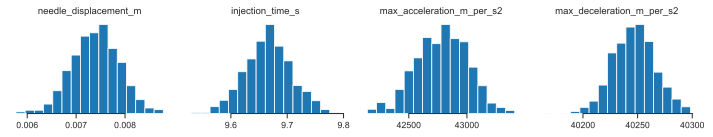

In [23]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 2), tight_layout=True)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(samples.squeeze(1)[:, i], bins=16, density=True)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

The uncertainty you see here is the *epistemic uncertainty* (or "lack-of-data" uncertainty). It should go down as we add more data points. We'll look at this next.

## Convergence: How much data do we need?

Ideally, we want to use enough data so that the epistemic uncertainty is low.
Let's test how much data we need for this problem.
We'll create training datasets of sizes $N=50, 100, 200, 500, 1000, 2000$ and observe the convergence of the trained GP.

In [24]:
dataset_sizes = [50, 100, 200, 500, 1000, 2000]
datasets_N = {size: create_dataset(size) for size in dataset_sizes}

surrogates_N = {}
trained_params_N = {}
loss_histories_N = {}

for N in dataset_sizes:
    print(f'Now training GP with dataset of size {N:<3} ... ')

    key, subkey = jr.split(key)
    X, y = datasets_N[N]
    key, subkey = jr.split(key)
    trained_params_N[N], loss_histories_N[N] = train_gps(init_params, X, y, num_iters=1000, learning_rate=1e-2, batch_size=100, key=subkey)
    gps = [build_gp(trained_params[o_name], X) for o_name in OUTPUT_NAMES]
    surrogates_N[N] = Surrogate(gps=gps, y_obs=y)

    print('done.')

Now training GP with dataset of size 50  ... 
Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP for max_deceleration_m_per_s2
done.
Now training GP with dataset of size 100 ... 
Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP for max_deceleration_m_per_s2
done.
Now training GP with dataset of size 200 ... 
Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP for max_deceleration_m_per_s2
done.
Now training GP with dataset of size 500 ... 
Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP for max_deceleration_m_per_s2
done.
Now training GP with dataset of size 1000 ... 
Training GP for needle_displacement_m
Training GP for injection_time_s
Training GP for max_acceleration_m_per_s2
Training GP 

In [25]:
y_latent_samples_N = {}
for i, N in enumerate(dataset_sizes):
    y_latent_samples_N[N] = surrogates_N[N].sample(X_s, num_samples=1000, key=key)  # Shape is (n_samples, n_points, n_outputs)

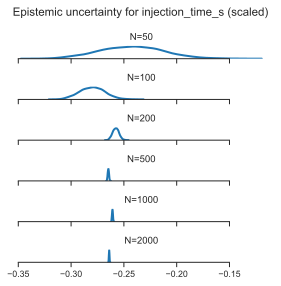

In [26]:
output_index = 1  # Select an output

fig, ax = plt.subplots(len(dataset_sizes), 1, figsize=(4, 4), tight_layout=True, sharex=True, sharey=False)
for i, N in enumerate(dataset_sizes):
    fig.suptitle(f'Epistemic uncertainty for {OUTPUT_NAMES[output_index]} (scaled)')
    sns.kdeplot(y_latent_samples_N[N].squeeze(1)[:,output_index], ax=ax[i], lw=2)
    ax[i].set_title(f'N={N}')
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    sns.despine(trim=True, ax=ax[i], left=True)

In [27]:
means_N = {}
stdevs_N = {}
for i, N in enumerate(dataset_sizes):
    s = surrogates_N[N].sample(X_s, num_samples=1000, key=key)
    means_N[N] = jnp.mean(s, axis=0)
    stdevs_N[N] = jnp.std(s, axis=0)

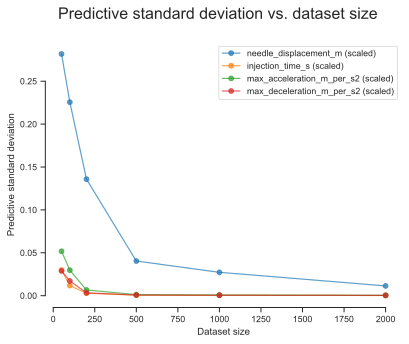

In [28]:
fig, ax = plt.subplots()
fig.suptitle('Predictive standard deviation vs. dataset size', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax.plot(dataset_sizes, [stdevs_N[N][0, i] for N in dataset_sizes], 'o-', label=f'{o_name} (scaled)', color=f'C{i}', alpha=0.7)
ax.set_xlabel('Dataset size')
ax.set_ylabel('Predictive standard deviation')
ax.legend()
sns.despine(trim=True, ax=ax)

For most of the outputs, we only need a few hundred data points.
(Predicting needle displacement accurately, however, will require more data or some inductive biases built into the surrogate.)

Finally, let's look at the parity plots for the GP trained on the most data.

In [29]:
surrogate = surrogates_N[2000]
samples = surrogate.sample(X_test_scaled, num_samples=1000, key=key)
means_test = samples.mean(axis=0)
stdevs_test = samples.std(axis=0)

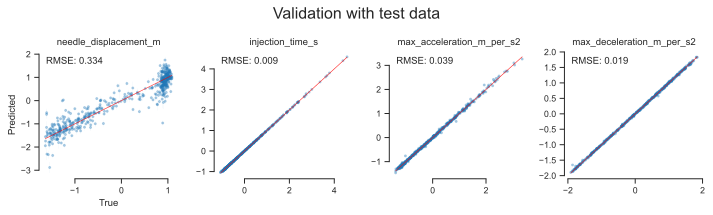

In [30]:
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Validation with test data', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].errorbar(y_test_scaled[:, i], means_test[:, i], yerr=2 * stdevs_test[:, i], fmt='o', ms=2, alpha=0.3, lw=0.1)
    ax[i].plot([y_test_scaled[:, i].min(), y_test_scaled[:, i].max()], [y_test_scaled[:, i].min(), y_test_scaled[:, i].max()], "r-", lw=0.5, zorder=100)
    ax[i].annotate(f"RMSE: {rmse(y_test_scaled[:, i], means_test[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted');

For most outputs, the fit is excellent.

## Sensitivity analysis with surrogate

Now that we have a trained and tested surrogate, there are many useful things we can do with it. As in the neural network surrogate hands-on activity, we'll demonstrate using the surrogate to do Sobol sensitivity analysis.

Now, let's create bounds for the inputs (based on physical intuition and/or literature values):

In [31]:
import SALib.sample.sobol as sobol
import SALib.analyze.sobol as analyze_sobol

input_bounds_dict = {
    'viscosity_cP': [1.0, 20.0],
    'fill_volume_mL': [1.0, 1.05],
    'air_gap_height_mm': [4.0, 5.0],
    'needle_length_mm': [8.0, 15.9],
    'needle_diameter_mm': [0.133, 0.21],
    'spring_force_N': [18.0, 36.0],
    'spring_constant_N_per_mm': [150.0, 250.0],
    'kappa5': [0.0, 3.0],
    'kappa6': [0.0, 4.0],
    'kappa7': [0.0, 0.1]
}
input_bounds = np.array([[input_bounds_dict[i][0], input_bounds_dict[i][1]] for i in INPUT_NAMES])
print('The input bounds are:\n', input_bounds)

The input bounds are:
 [[1.00e+00 2.00e+01]
 [1.00e+00 1.05e+00]
 [4.00e+00 5.00e+00]
 [8.00e+00 1.59e+01]
 [1.33e-01 2.10e-01]
 [1.80e+01 3.60e+01]
 [1.50e+02 2.50e+02]
 [0.00e+00 3.00e+00]
 [0.00e+00 4.00e+00]
 [0.00e+00 1.00e-01]]


Next, we create Sobol samples of the inputs and pass them through the surrogate:

In [32]:
problem = {
    'num_vars': len(INPUT_NAMES),
    'names': INPUT_NAMES,
    'bounds': input_bounds
}

# The number of samples to generate (should be a power of 2).
N = 512

# Generate the samples.
sobol_samples = sobol.sample(problem, N, calc_second_order=False)
sobol_samples_scaled = scale_x(sobol_samples)

# Evaluate the surrogate model at the Sobol samples.
sobol_outputs = surrogate.mean(sobol_samples_scaled)

Finally, we calculate and plot the Sobol indices:

In [33]:
sobol_indices = {}
for i, o_name in enumerate(OUTPUT_NAMES):
    sobol_indices[o_name] = analyze_sobol.analyze(problem, sobol_outputs[:, i], calc_second_order=False, print_to_console=False)

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


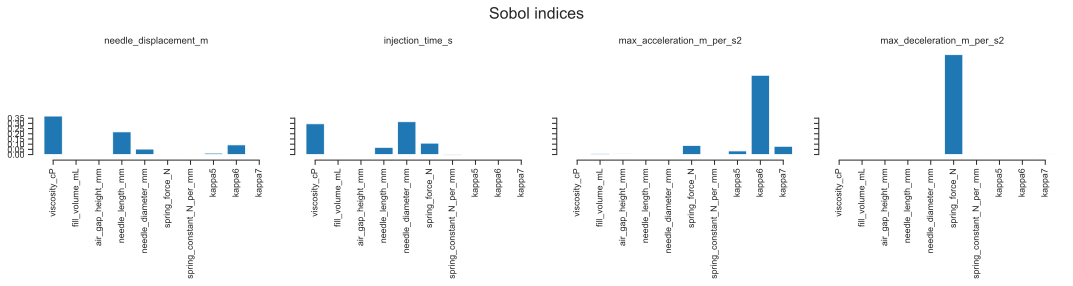

In [34]:
# Plot sobol indices
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(15, 4), tight_layout=True, sharey=True)
fig.suptitle('Sobol indices', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].bar(problem['names'], sobol_indices[o_name]['S1'])
    ax[i].set_title(o_name)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    sns.despine(trim=True, ax=ax[i])

Excellent! We now know to which inputs the outputs are most sensitive. For example, we can see that the injection time is *very* sensitive to the drug viscosity and needle diameter, *somewhat* sensitive to needle length and injector spring force, and *not* sensitive to any other inputs. This information can be used, for example, to further study and understand the physics behind the model, or to investigate how identifiable each parameter is given an experimental dataset.

Remember that **sensitivity analysis would *not* have been feasible without a surrogate model**&mdash;the true physical model was just too expensive. With a surrogate however, we can do sensitivity analysis, design optimization, uncertainty quantification, etc. all at a reasonable computational cost.